## Data fitting by $\chi^2$ minimisation in Python - this is the approach that you should use to fit your data!

This notebook provides several examples of how to do an efficient and robust chi-squared minimisation using the `scipy.optimize.curve_fit` function. A minimal version of the important parts of this notebook, without any explanation or commentary included, is also provided as `curve_fit.ipynb` for you to use to fit your data.

We will use example data that you have seen before, the same straight-line dataset that we have previously seen fitted as an example of using chi-squared in Python in `example_chi-squared.ipynb`, and the damped oscillator data that you fitted using Excel during Skills session 2. Also most of the code here is similar to that seen before in `example_chi-squared.ipynb`. The difference is in how we do the fitting; using a more common `scipy` function that uses chi-squared minimisation internally. This is a little more robust than the approach we have seen so-far (calculating chi-squared ourselves and minimising this) although less demonstrative of the chi-squared technique since it is effectively hiddedn from you.

**Important:** You will see this approach used extensively online, however many examples use it somewhat **incorrectly** - at least in terms of extracting the parameter uncertainties that we are interested in as physicists, the standard error. So, do not unthinkingly reuse code that you might find on StackOverflow or generate using ChatGPT!



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import scipy.optimize
import scipy.stats

After importing some common modules, we need some data - as an illustration, here we use `StringIO` to 'pretend' that the data is a text file, with our data as three columns - x, y and y-error, which we then load into some arrays using `numpy.loadtxt`. This will be useful in future, when you will need to load larger datasets in from files.



In [2]:
from io import StringIO

filedata = StringIO("0 70 0.8\n" 
                    "15 77 0.7\n"
                    "30 83 1.2\n" 
                    "45 90 1.1\n" 
                    "60 100 1.2\n")

The first line in the cell below loads the data into three data arrays - this then produces the same result as in `example_chi-squared.ipynb`, where we difined our data directly by

```python
x_values = numpy.array([0, 15, 30, 45, 60])
y_values = numpy.array([70, 77, 83, 90, 100])
y_errors = numpy.array([0.8, 0.7, 1.2, 1.1, 1.2])
```

Normally, `filedata` would be replaced by the name of your datafile, and `unpack=True` is used to turn the 3 columns of data into 3 arrays. More information on using `numpy.loadtxt` (there are many options for differnt data formats) can be found in the `numpy` documentation (https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html).

It is useful to check that we have entered (or loaded) the data correctly - that there are the **same** number of values in each array. We can use `assert`s to do this; if the length of the arrays are different, it will cause an `AssertionError` - it is easier to track down the problem at this point than later. You will have seen similar `assert` statements within your Computational Physics assignments, where it is used to check that you have obtained the correct result, for example.

We also plot a simple graph of the data to check that everything is as it should be.

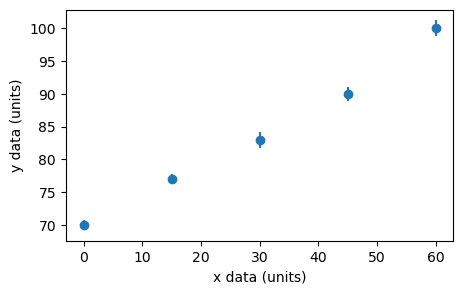

In [3]:
x_values, y_values, y_errors = numpy.loadtxt(filedata, unpack=True) # read columns of data from 'file'

assert len(y_values) == len(x_values)
assert len(y_errors) == len(y_values)

plt.figure(figsize=(5,3))
plt.errorbar(x_values, 
             y_values, 
             yerr=y_errors, # use y_errors array for y error bars
             marker='o',    # circular markers at each datapoint
             linestyle='None') # no connecting lines

plt.xlabel('x data (units)') # axis labels and units
plt.ylabel('y data (units)')
plt.show() 

---

Next we again define the functional form of the model: `params` is a numpy array holding the parameter values, again gradient and intercept.

**Important:** There is a slight difference to what we did in `example_chi-squared.ipynb`. Due to an implementation detail of `scipy.optimize.curve_fit` we now need to specify our parameter values as `*params` rather that `params`. 

We again define an array of initial values.

**Important:** With more fitting parameters - a higher-dimensional parameter space to explore - specifying sensible starting values for the fit becomes increasingly important!


In [4]:
def model_function(x, *params):
    return params[0]*x + params[1]


initial_values = numpy.array([0.5, 70.0]) # Initial guess for fit parameters

When we use this model function we need to call it with the parameter array 'unpacked' with `*`. For example, we define a function which we will later use to calculate chi-squared; this is slightly different to the equivalent function in `example_chi-squared.ipynb`, as now we need to unpack the array `params` with `*` in the call to the function `model`.

In [5]:
def chi_squared(model_params, model, x_data, y_data, y_err):
    return numpy.sum(((y_data - model(x_data, *model_params))/y_err)**2) # Note the `*model_params' here!

degrees_of_freedom = x_values.size - initial_values.size

We again use the sizes of the initial value and data arrays to determine the number of degrees-of-freedom.


---

Now we produce the fit using the `curve_fit` function from the `scipy.optimize` module. `curve_fit` uses chi-squared internally, which is much more efficient and robust than programming our own chi-squared minimisation.

`curve_fit` produces two outputs: a vector (array) of optimised parameters, which is commonly called `popt`, and a covariance matrix (see Hughes & Hase, p92), which is commonly called `cov` - we will use this to determine the uncertainties in the optimised parameters.

**Important** `scipy.optimize.curve_fit()` should (almost) ALWAYS be called with '`absolute_sigma=True`'. This specifies that the stated error-bars represent 1 standard error in the datapoints, and so the resulting covariance matrix also is representative of 1 standard error in the fitted parameters. The default value of `absolute_sigma` is actually `False`, which instead returns a covariance matrix representative of errors scaled such that the minimised chi-squared is exactly 1: as physicists this is not usually what we want!

---

You **may** encounter a circumstance  in your experiments where you are unsure of the correct size of your error-bars, but you do know that they are all the same (homoscedastic). In such a case, and where you already 'know' that the model that you are using has the correct functional form - so expect a reduced chi-squared close to unity - using `absolute_sigma=False` does then give the 'correct' uncertainties in the parameters from the covariance matrix.

---

**Important:** `scipy.optimize.curve_fit` does NOT return a warning message if the fit does not complete: you NEED 
to CHECK that the fit produces sensible, OPTIMUM, output (e.g. by plotting) rather than unthinkingly accepting the results.

In [6]:
popt, cov = scipy.optimize.curve_fit(model_function, # function to fit
                                     x_values, # x data
                                     y_values, # y data
                                     sigma=y_errors, # array of error bars for the fit
                                     absolute_sigma=True, # errors bars DO represent 1 std error
                                     p0=initial_values, # starting point for fit
                                     check_finite=True) # raise ValueError if NaN encountered (don't allow errors to pass)

print('Optimised parameters = ', popt, '\n')
print('Covariance matrix = \n', cov)

Optimised parameters =  [ 0.47874738 69.70677976] 

Covariance matrix = 
 [[ 0.00042739 -0.00957103]
 [-0.00957103  0.38619383]]


To check that the fit has completed, plot the data and best fit. If it has not produced a good fit you may need to re-run the fit, using the current values of `popt` as the new starting point.

**Important:** When using our model function to generate the fit lines, we again need to 'unpack' the optimised parameter array by passing `*popt` - as in our chi-squared function.

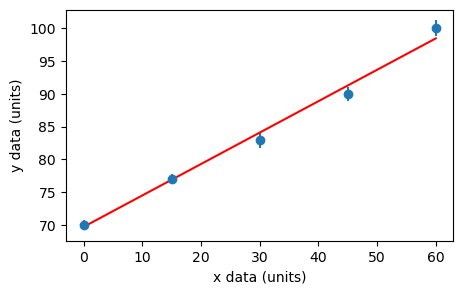

In [7]:
plt.figure(figsize=(5,3))
plt.errorbar(x_values, 
             y_values, 
             yerr=y_errors, 
             marker='o', 
             linestyle='None')

plt.xlabel('x data (units)') # Axis labels
plt.ylabel('y data (units)')

# Generate best fit using model function and best fit parameters, and add to plot
plt.plot(x_values, 
         model_function(x_values, *popt), 
         color='r')

plt.show()

Assuming that the fit looks reasonable, we determine the chi-squared, finally using the function that we defined ourselves above, and from this the reduced chi-squared and the p-value.

In [8]:
chi_squared_min = chi_squared(popt, model_function, x_values, y_values, y_errors)
print('chi^2_min = {}'.format(chi_squared_min))
print('reduced chi^2 = {}'.format(chi_squared_min/degrees_of_freedom))
print('P(chi^2_min, DoF) = {}'.format(scipy.stats.chi2.sf(chi_squared_min, degrees_of_freedom)))

print('best fit slope = {} units?'.format(popt[0]))
print('best fit intercept = {} units?'.format(popt[1]))

chi^2_min = 3.9542011412747287
reduced chi^2 = 1.3180670470915763
P(chi^2_min, DoF) = 0.2664522363595677
best fit slope = 0.4787473758917269 units?
best fit intercept = 69.7067797637413 units?


---

## Uncertainties

Uncertainties in the parameters now correspond to the square-root of the diagonal elements of the covariance matrix,

$$ \alpha_j = \sqrt{C_{jj}}.$$

Helpfully, this is very easy to do in `numpy`!

In [9]:
popt_errs = numpy.sqrt(numpy.diag(cov))
print(popt_errs)

[0.02067352 0.62144496]


Print each parameter and uncertainty:

In [10]:
for i, (val, err) in enumerate(zip(popt, popt_errs)):
    print('optimised parameter[{}] = ({} +/- {}) units'.format(i, val, err))

optimised parameter[0] = (0.4787473758917269 +/- 0.020673518203781664) units
optimised parameter[1] = (69.7067797637413 +/- 0.6214449556045205) units


Don't forget about the 5 Golden Rules for stating values and uncertainties - a computer doesn't think about significant figures, but a physicist does!


1. The best estimate of the parameter is the **mean**.
2. The error is the **standard error** in the mean.
3. Round up the error to the appropriate number of **significant figures** (usually one).
4. Match the number of **decimal places** in the mean to the standard error.
5. Include the appropriate **units**.

---

## Contour plots

It is sometimes useful to inspect a contour plot of the chi-squared parameter space - and recall that the extrema of the contour where chi-squared has increased by unity from its minimum value also correspond to the standard error in the parameters. We can only visualise these contour plots for a 2D parameter space. 

We generate data for 2D plots of the chi-squared landscape which will allow us to produce contour plots. The data for the 2D plot is calculated for a grid of points centered on the solution `(popt[0], popt[1])`, with  ranges `+/- p0_range` and `+/- p1_range`. We will use the errors extracted from the icovariance matrix to set the plotting range automatically - multiplying by 3.5 should produce a contour plot containing the first three confidence interval contours.

We generate a grid of `n_points` x `n_points` over the above ranges of parameter values and evaluate chi-squared at each point. If you make `n_points` small the grid will be 'blocky'. If you make `n_points` large it takes longer to calculate.

In [11]:
assert(popt.size == 2) # contour plot only 'works' for 2D parameter space!

extent = 3.5 # standard errors
n_points = 100 # mesh density         

p0_range = extent * popt_errs[0]
p1_range = extent * popt_errs[1]

# Generate grid and data
p0_axis = numpy.linspace(popt[0]-p0_range, popt[0]+p0_range, num=n_points)
p1_axis = numpy.linspace(popt[1]-p1_range, popt[1]+p1_range, num=n_points)
plot_data = numpy.zeros((n_points, n_points))

for j, p1_val in enumerate(p1_axis): 
    for i, p0_val in enumerate(p0_axis): # Nested loops for 'clarity'...
        plot_data[j][i] = chi_squared([p0_val, p1_val], # function evaluated n_points*n_points times!
                                      model_function, 
                                      x_values, 
                                      y_values, 
                                      y_errors)

To show that we have indeed calculated the chi-squared value at every point on the grid, first we produce a colour plot of chi-squared landscape.

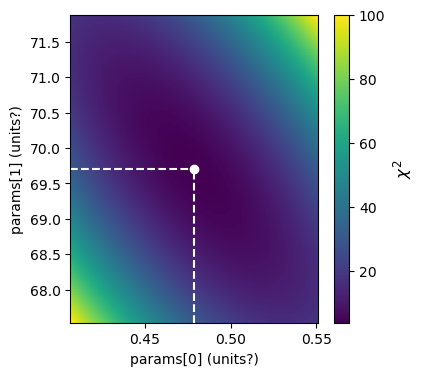

In [12]:
assert(popt.size == 2) # contour plot only 'works' for 2D parameter space!

plt.figure(figsize=(4,4))
im = plt.imshow(plot_data, # grid of chi-squared values
                extent=(p0_axis[0], p0_axis[-1], # 'x' range
                        p1_axis[0], p1_axis[-1]), # 'y' range
                origin='lower', aspect='auto')

plt.xlim(popt[0]-p0_range, popt[0]+p0_range) # axis ranges
plt.ylim(popt[1]-p1_range, popt[1]+p1_range)

plt.ylabel('params[1] (units?)') # Axis labels
plt.xlabel('params[0] (units?)')

cbar=plt.colorbar(im, orientation='vertical') # Colorbar and label
cbar.set_label('$\chi^2$', fontsize=12)

# Add in best fit point and dashed lines to the axes
plt.plot(popt[0], popt[1], 'wo') 
plt.plot((popt[0], popt[0]), (p1_axis[0], popt[1]), # vertical line
         linestyle='--', color='w')
plt.plot((p0_axis[0], popt[0]), (popt[1], popt[1]), # horizontal line
         linestyle='--', color='w')
plt.show()

This should 'confirm' that the 'best fit' parameter values do indeed correspond to the minimum in the chi-squared landscape. This information is useful in that it tells you by how much chi-squared changes over the range that you have plotted. It is somewhat easier to interpret when we plot this as contours instead of a colourmap... 

As a more useful example, we will produce a contour plot of $\Delta \chi^2 (= \chi^2(X,Y) - \chi^2_{min})$.

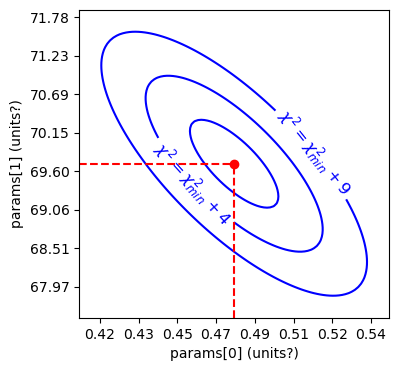

In [13]:
assert(popt.size == 2) # contour plot only 'works' for 2D parameter space!

X, Y = numpy.meshgrid(p0_axis, p1_axis, indexing='xy')
contour_data = plot_data - chi_squared_min

levels = [1, 4, 9] # Contour levels in delta chi-squared of 1, 4 & 9 correspond to 1, 2 & 3 standard errors
plt.figure(figsize=(4,4))

#Plot and label contours: (comment out labelling to remove text over contours)
contour_plot = plt.contour(X, Y, contour_data, levels=levels, colors='b', origin='lower')
plt.clabel(contour_plot, levels, fontsize=12, inline=1, fmt=r'$\chi^2 = \chi^2_{min}+%1.0f$') 

plt.xlabel('params[0] (units?)') 
plt.ylabel('params[1] (units?)')

import matplotlib.ticker as ticker # Allows you to modify the tick markers to 
xtick_spacing = p0_range/4         # assess the errors from the chi-squared 
ytick_spacing = p1_range/4         # contour plots - set as appropriate
 
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(xtick_spacing))
ax.xaxis.set_major_formatter('{x:.2f}') # 2 decimal places - may or may not be appropriate!

ax.yaxis.set_major_locator(ticker.MultipleLocator(ytick_spacing))
ax.yaxis.set_major_formatter('{x:.2f}') # 2 decimal places - may or may not be appropriate!

# Add in best fit point and dashed lines to the axes
plt.plot(popt[0], popt[1], 'ro') 
plt.plot((popt[0], popt[0]), (p1_axis[0], popt[1]), linestyle='--', color='r')
plt.plot((p0_axis[0], popt[0]), (popt[1], popt[1]), linestyle='--', color='r')
plt.show()

You can obtain a reasonable estimate to the uncertainty simply by reading off from the contour plot the position of the extrema of the contour where chi-squared increases by 1.

It is possible to determine error bars from the extrema of the 𝜒2𝑚𝑖𝑛+1
contour in 2D parameter space using a little matplotlib trickery:

In [14]:
assert(popt.size == 2) # contour plot only 'works' for 2D parameter space!

contours = contour_plot.collections[0].get_paths() # Get the contours from the plot
onesigma_contour = contours[0].vertices # Get the set of points constituting the one confidence-interval contour
      
# Get the extrema along the two axes - max and min values. These should be symmetric about the solution.
maxs = numpy.amax(onesigma_contour, axis=0)   
mins = numpy.amin(onesigma_contour, axis=0)   
errs_graphical = (maxs - mins)/2  # Half the difference is one standard error in the parameters

for i, (v, e) in enumerate(zip(popt, errs_graphical)):
    print('params[{}] = ({} +/- {}) units'.format(i, v, e))           


params[0] = (0.4787473758917269 +/- 0.020646201686632754) units
params[1] = (69.7067797637413 +/- 0.6206238164483011) units


As an illustrative example, this should confirm that the two approaches return similar values for the uncertainty, at least within the precision that it is reasonable for us to state the uncertainty.

It is worth noting that both values are approximations: The graphical approach due to the resolution - `n_points` ×
`n_points` - of the grid of chi-squared values that we calculate (plus some internal details of how matplotlib interpolates to determine the contour data); the covariance matrix determined by `scipy.optimize.curve_fit` is also an approximation which depends on details of the minimization approach and settings.

---
---

## More complex dataset

This is the damped oscillator dataset that you fitted in Excel during Skills session 2. The model function for this is

$$h\left( t\right) =  A \sin \left( \frac{2 \pi t}{T} + \phi \right) \exp \left(-\frac{t}{\tau} \right),$$

where our fitting parameters are the amplitude $A$, period $T$, phase $\phi$, and time constant $\tau$.

In [15]:
x_values = numpy.array([0.00, 0.03, 0.05, 0.08, 0.10, 0.13, 0.15, 0.18, 0.20, 0.23, 0.25, 0.28, 0.30, 0.33, 0.35, 0.38, 
                        0.40, 0.43, 0.45, 0.48, 0.50, 0.53, 0.55, 0.58, 0.60, 0.63, 0.65, 0.68, 0.70, 0.73, 0.75, 0.78, 
                        0.80, 0.83, 0.85, 0.88, 0.90, 0.93, 0.95])
y_values = numpy.array([12.01, 9.31, 2.44, -6.61, -10.54, -12.92, -7.64, -1.01, 5.78, 9.69, 10.87, 7.07, -0.27, -6.78, 
                        -9.54, -8.48, -3.44, 2.55, 7.57, 9.27, 6.02, 2.98, -2.82, -7.12, -6.86, -4.95, -1.38, 4.10, 
                        7.78, 7.19, 6.10, 0.74, -5.05, -7.29, -6.62, -2.25, -0.01, 5.53, 4.05])
y_errors = numpy.array([0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 
                        0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 
                        0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75])

def model_function(x, *params):
    '''Damped oscillator'''
    return params[0]*numpy.sin(2*numpy.pi*x/params[1] + params[2])*numpy.exp(-x/params[3])


initial_values = numpy.array([15.0, 0.2, 0.0, 1.0]) # Initial guess for fit parameters

Again, with more fitting parameters, and particularly with periodic functions, specifying sensible starting values for the fit is important!

Fit the data, and plot the output. Here we use a larger number of points to generate the fit line that we plot, so give a smoother curve.

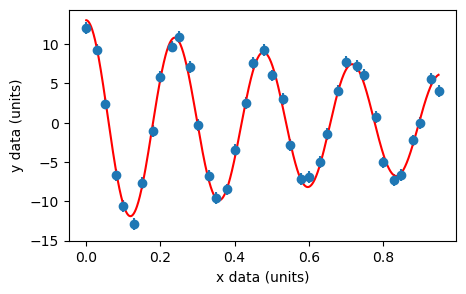

In [16]:
popt, cov = scipy.optimize.curve_fit(model_function, # function to fit
                                     x_values, # x data
                                     y_values, # y data
                                     sigma=y_errors, # array of error bars for the fit
                                     absolute_sigma=True, # errors bars DO represent 1 std error
                                     p0=initial_values, # starting point for fit
                                     check_finite=True) # raise ValueError if NaN encountered (don't allow errors to pass)

plt.figure(figsize=(5,3))
plt.errorbar(x_values, 
             y_values, 
             yerr=y_errors, 
             marker='o', 
             linestyle='None')
plt.xlabel('x data (units)') # Axis labels
plt.ylabel('y data (units)')

smooth_x = numpy.linspace(x_values[0], x_values[-1], 1000) # more points, over range of data
plt.plot(smooth_x, 
         model_function(smooth_x , *popt), 
         color='r')
plt.show()

Assuming the fit appears reasonable, determine chi-squared etc. 

If reduced chi-squared is sufficiently close to unity, we can determine the best fitting parameter values and their associated uncertainties from the covariance matrix.

In [17]:
chi_squared_min = chi_squared(popt, model_function, x_values, y_values, y_errors)
print('chi^2_min = {}'.format(chi_squared_min))

degrees_of_freedom = x_values.size - popt.size
print('reduced chi^2 = {}'.format(chi_squared_min/degrees_of_freedom))
print('P(chi^2_min, DoF) = {}'.format(scipy.stats.chi2.sf(chi_squared_min, degrees_of_freedom)))


popt_errs = numpy.sqrt(numpy.diag(cov))

for i, (val, err) in enumerate(zip(popt, popt_errs)):
    print('optimised parameter[{}] = ({} +/- {}) units'.format(i, val, err))
    


chi^2_min = 53.391084560694615
reduced chi^2 = 1.525459558876989
P(chi^2_min, DoF) = 0.024022375395644766
optimised parameter[0] = (13.04648981218937 +/- 0.3819969314955347) units
optimised parameter[1] = (0.23914311338395747 +/- 0.0006396787904910461) units
optimised parameter[2] = (1.5546065071686352 +/- 0.03147781107568698) units
optimised parameter[3] = (1.2801723309109438 +/- 0.1077172575877061) units
